In [64]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\dataset.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\target.csv', header = 0)

[(0, 'balance'), (1, 'N_maxpayment'), (2, 'investment_in'), (3, 'payment_out'), (4, 'mean_v1'), (5, 'sdev_v1'), (6, 'skew_v1'), (7, 'mean_v2'), (8, 'sdev_v2'), (9, 'skew_v2'), (10, 'known_rate'), (11, 'paid_rate'), (12, 'paid_one')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

In [4]:
# vado a stampare il numero di non ponzi e ponzi presenti nel train set e nel test_set
flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3107
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 777
Number of smart Ponzi in test set:: 135


In [65]:
param_dist_DT = {
    'criterion' : ['entropy', 'gini'],
    'max_depth' : [6, 7, 8, 9, 10],
    'min_samples_split' : [10, 15, 20], # il valore tipico sta fra 1 e 40
    'class_weight' : [{0:1, 1:4.75}, {0:1, 1:5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
}

In [66]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_dist_DT, cv=3, n_jobs=8)

grid_dt.fit(X_train, y_train) # alleno su train
y_pred_train = grid_dt.predict(X_train) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'class_weight': {0: 1, 1: 4.75}, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20}
best score::  0.7909465020576132
recall score on TR::  0.8066914498141264
precision score on TR::  0.4177093358999038


In [67]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_dt.score(X_train, y_train))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8054869684499314
accuracy score on TS::  0.7796052631578947


In [69]:
param_dist_RF = {
            'n_estimators':[150, 170, 190, 200],
            'max_depth' : [8, 9, 10],
            'min_samples_split' : [35],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
}

In [70]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_dist_RF, cv=3, n_jobs=8)
grid_rf.fit(X_train, y_train.ravel())
y_pred_train = grid_rf.predict(X_train)
print('best hyperparameters:: ', grid_rf.best_params_)
print('best score:: ', grid_rf.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'bootstrap': True, 'class_weight': {0: 1, 1: 5.5}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 35, 'n_estimators': 170}
best score::  0.8063100137174212
recall score on TR::  0.7769516728624535
precision score on TR::  0.4583333333333333


In [71]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_rf = RandomForestClassifier(**grid_rf.best_params_)
clf_rf.fit(X_train, y_train.ravel())
print('accuracy score on TR:: ', clf_rf.score(X_train, y_train))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.8318244170096022
accuracy score on TS::  0.7982456140350878


In [73]:
grid_param_XGB = {
                'learning_rate' : [0.05],
                'n_estimators' : [150, 170, 190, 200],
                'max_depth' : [9, 10],
                'colsample_bytree' : [0.8],
                'scale_pos_weight' : [6],
                'gamma' : [0.1, 0.25, 0.4],
                'reg_lambda' : [50]
}

In [74]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_xgb = GridSearchCV(xgb.XGBClassifier(subsample = 0.8, use_label_encoder = False, eval_metric = 'aucpr'), 
                        param_grid = grid_param_XGB, cv = 3, n_jobs = 8)
grid_xgb.fit(X_train, y_train)
y_pred_train = grid_xgb.predict(X_train)
print('best hyperparameters:: ', grid_xgb.best_params_)
print('best score:: ', grid_xgb.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 50, 'scale_pos_weight': 6}
best score::  0.8065843621399177
recall score on TR::  0.8159851301115242
precision score on TR::  0.5158636897767332


In [77]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_xgb = xgb.XGBClassifier(learning_rate = 0.05, n_estimators = 200, scale_pos_weight = 6, reg_lambda = 50, gamma =0.1,
                            subsample = 0.8, colsample_bytree = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_xgb.score(X_train, y_train))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.8326474622770919
accuracy score on TS::  0.8037280701754386


In [87]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8, 9, 10],
            'min_samples_split' : [10, 15, 20], # il valore tipico sta fra 1 e 40
            'class_weight' : [{0:1, 1:4.75}, {0:1, 1:5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(min_samples_split = 35),
        'params': {
            'n_estimators':[200, 210, 220, 230, 240, 250],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(learning_rate = 0.05,
                                   subsample = 0.8, 
                                   scale_pos_weight  =6, 
                                   colsample_bytree = 0.8,
                                   reg_lambda = 50,
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'n_estimators' : [150, 170, 190, 200],
                'max_depth' : [9, 10],
                'gamma' : [0.1, 0.25, 0.4],
        }
    }
}

In [88]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.794239,"{'class_weight': {0: 1, 1: 4.75}, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 15}"
1,random_forest,0.820850,"{'bootstrap': True, 'class_weight': {0: 1, 1: 5.5}, 'criterion': 'entropy', 'n_estimators': 230}"
2,xgboost,0.806584,"{'gamma': 0.1, 'max_depth': 10, 'n_estimators': 200}"


In [89]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train.ravel()) # rialleno

RandomForestClassifier(class_weight={0: 1, 1: 5.5}, criterion='entropy',
                       min_samples_split=35, n_estimators=230)

     (Number, Feature)  Importance
0       (12, paid_one)    0.140216
1     (10, known_rate)    0.117471
2         (8, sdev_v2)    0.108247
3         (4, mean_v1)    0.100659
4      (11, paid_rate)    0.095004
5   (2, investment_in)    0.081875
6         (5, sdev_v1)    0.064500
7         (6, skew_v1)    0.058652
8     (3, payment_out)    0.054163
9         (9, skew_v2)    0.051485
10   (1, N_maxpayment)    0.047318
11        (0, balance)    0.043363
12        (7, mean_v2)    0.037046


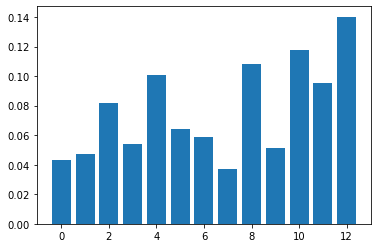

In [90]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.42045454545454547
recall score::  0.5481481481481482
accuracy score::  0.8212719298245614
F1 score:: 0.4758842443729904


<AxesSubplot:>

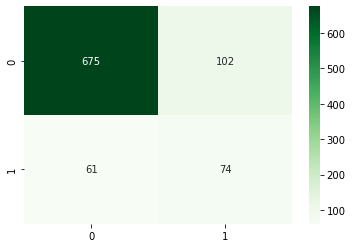

In [91]:
y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

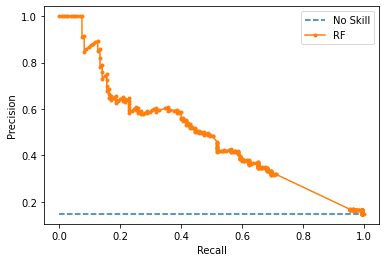

In [92]:
# predict probabilities
y_pred_proba = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_proba = y_pred_proba[:, 1]
# calculate pr-curve
p, r, thrs = precision_recall_curve(y_test, y_pred_proba)
# plot the roc curve for the model
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(r, p, marker = '.', label = 'RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [93]:
# convert to f score
beta = 1.75 # se metto valori <= 1 allora e' come favorire F1 o precision, piu' alzo beta e piu' importanza ha la recall
fbeta = ((1 + beta**2) * p * r) / (beta**2 * p + r)
# locate the index of the largest f score
ix = np.argmax(fbeta)
print('Best Threshold = %f, Fbeta-Score = %.3f' % (thrs[ix], fbeta[ix]))

Best Threshold = 0.303256, Fbeta-Score = 0.551


<AxesSubplot:>

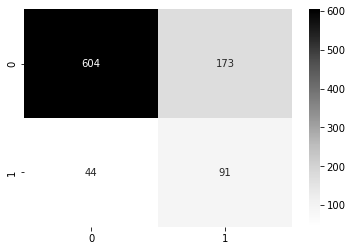

In [94]:
y_pred_thrs = np.where(clf.predict_proba(X_test)[:, 1] > thrs[ix], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')

In [95]:
# salvo su di un file le predizioni e i ground truth con eseguiro' il test McNemar.
y_test_list = [item for sublist in y_test for item in sublist]
y_pred_thrs_list = y_pred_thrs.tolist()
y_test_file = open(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\y_test_list.txt', "w")
for element in y_test_list:
    y_test_file.write(str(element) + "\n")
y_test_file.close()


y_pred_file = open(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\exploiting blockchain - cleaned\y_pred_list.txt', "w")
for element in y_pred_thrs_list:
    y_pred_file.write(str(element) + "\n")
y_pred_file.close()